In [ ]:
# !curl -O https://files.grouplens.org/datasets/movielens/ml-100k.zip
# !unzip ml-100k.zip

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import pickle
from collections import defaultdict

# Surprise library imports
from surprise import Dataset, Reader
from surprise import SVD, NMF, KNNBasic, BaselineOnly, SlopeOne
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate
from surprise import accuracy
## NN
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import time
from collections import defaultdict
# Set random seed for reproducibility
np.random.seed(42)

# Function to load and prepare the MovieLens 100K dataset
def load_movielens_100k():
    """
    Load the MovieLens 100K dataset using Surprise's built-in functionality
    """
    print("Loading MovieLens 100K dataset...")
    # Use the built-in movielens-100k dataset
    data = Dataset.load_builtin('ml-100k')
    
    # For a more custom approach with the downloaded files, you could use:
    # reader = Reader(line_format='user item rating timestamp', sep='\t')
    # data = Dataset.load_from_file('path/to/ml-100k/u.data', reader=reader)
    
    # Split the data into train and test sets
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
    
    print(f"Dataset loaded. Training set size: {len(trainset.build_anti_testset())}, Test set size: {len(testset)}")
    return data, trainset, testset

# Function to load movie information
def load_movie_info():
    """
    Load movie information (title, genres) from the MovieLens 100K dataset
    """
    try:
        # Load movie information (title, genres)
        movies_df = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1', 
                              header=None, names=['movie_id', 'title', 'release_date', 'video_release_date', 
                                                 'imdb_url'] + [f'genre_{i}' for i in range(19)])
        
        # Extract year from title
        movies_df['year'] = movies_df['title'].str.extract(r'\((\d{4})\)$', expand=False)
        
        # Create genre list
        genre_columns = [col for col in movies_df.columns if 'genre_' in col]
        movies_df['genres'] = movies_df[genre_columns].apply(
            lambda x: [i for i, v in enumerate(x) if v == 1], axis=1
        )
        
        # Map genre indices to names (based on MovieLens 100K documentation)
        genre_names = ['Unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 
                       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
                       'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 
                       'War', 'Western']
        
        movies_df['genre_names'] = movies_df['genres'].apply(
            lambda indices: [genre_names[idx] for idx in indices]
        )
        
        return movies_df
    except FileNotFoundError:
        print("Movie information file not found. Please make sure the 'ml-100k' folder is in your working directory.")
        return pd.DataFrame()

# Function to implement baseline models
def implement_baseline_models(data, trainset, testset):
    """
    Implement and evaluate baseline recommendation models:
    1. Popularity-based (BaselineOnly)
    2. User-based collaborative filtering (KNNBasic with user_based=True)
    3. Item-based collaborative filtering (KNNBasic with user_based=False)
    """
    print("\n" + "="*50)
    print("IMPLEMENTING BASELINE MODELS")
    print("="*50)
    
    # Define models to evaluate
    models = {
        'Popularity-based (BaselineOnly)': BaselineOnly(),
        'User-based CF': KNNBasic(k=40, min_k=1, sim_options={'name': 'pearson', 'user_based': True}),
        'Item-based CF': KNNBasic(k=40, min_k=1, sim_options={'name': 'pearson', 'user_based': False})
    }
    
    # Dictionary to store results
    baseline_results = {}
    
    # Evaluate each model
    for name, model in models.items():
        print(f"\nEvaluating {name}...")
        start_time = time.time()
        
        # Train the model
        model.fit(trainset)
        
        # Make predictions on the test set
        predictions = model.test(testset)
        
        # Calculate metrics
        rmse = accuracy.rmse(predictions)
        mae = accuracy.mae(predictions)
        
        # Additional metrics (precision and recall)
        # For simplicity, we'll consider a rating >= 4 as relevant
        precision, recall = calculate_precision_recall(predictions, threshold=4)
        
        # Store results
        baseline_results[name] = {
            'model': model,
            'rmse': rmse,
            'mae': mae,
            'precision': precision,
            'recall': recall,
            'training_time': time.time() - start_time
        }
        
        print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")
        print(f"Precision@k: {precision:.4f}, Recall@k: {recall:.4f}")
        print(f"Training time: {baseline_results[name]['training_time']:.2f} seconds")
    
    # Identify the best model
    best_model_name = min(baseline_results, key=lambda x: baseline_results[x]['rmse'])
    print(f"\nBest baseline model based on RMSE: {best_model_name}")
    
    return baseline_results

# Function to implement matrix factorization models
def implement_matrix_factorization(data, trainset, testset):
    """
    Implement and evaluate matrix factorization models:
    1. SVD (Singular Value Decomposition)
    2. NMF (Non-negative Matrix Factorization)
    """
    print("\n" + "="*50)
    print("IMPLEMENTING MATRIX FACTORIZATION MODELS")
    print("="*50)
    
    # Define models to evaluate
    mf_models = {
        'SVD (default)': SVD(),
        'NMF (default)': NMF()
    }
    
    # Dictionary to store results
    mf_results = {}
    
    # Evaluate each model with default parameters
    for name, model in mf_models.items():
        print(f"\nEvaluating {name}...")
        start_time = time.time()
        
        # Train the model
        model.fit(trainset)
        
        # Make predictions on the test set
        predictions = model.test(testset)
        
        # Calculate metrics
        rmse = accuracy.rmse(predictions)
        mae = accuracy.mae(predictions)
        
        # Additional metrics (precision and recall)
        precision, recall = calculate_precision_recall(predictions, threshold=4)
        
        # Store results
        mf_results[name] = {
            'model': model,
            'rmse': rmse,
            'mae': mae,
            'precision': precision,
            'recall': recall,
            'training_time': time.time() - start_time
        }
        
        print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")
        print(f"Precision@k: {precision:.4f}, Recall@k: {recall:.4f}")
        print(f"Training time: {mf_results[name]['training_time']:.2f} seconds")
    
    print("\nPerforming grid search for SVD hyperparameter tuning...")
    
    # Define hyperparameter grid for SVD
    param_grid = {
        'n_factors': [50, 100, 150],
        'n_epochs': [20, 30],
        'lr_all': [0.005, 0.01],
        'reg_all': [0.02, 0.1]
    }
    
    # Perform grid search
    gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
    gs.fit(data)
    
    # Best parameters
    svd_params = gs.best_params['rmse']
    print(f"Best SVD parameters: {svd_params}")
    
    # Train the tuned SVD model
    print("\nTraining SVD with tuned parameters...")
    svd_tuned = SVD(**svd_params)
    start_time = time.time()
    svd_tuned.fit(trainset)
    
    # Evaluate the tuned model
    predictions = svd_tuned.test(testset)
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)
    precision, recall = calculate_precision_recall(predictions, threshold=4)
    
    # Store results
    mf_results['SVD (tuned)'] = {
        'model': svd_tuned,
        'parameters': svd_params,
        'rmse': rmse,
        'mae': mae,
        'precision': precision,
        'recall': recall,
        'training_time': time.time() - start_time
    }
    
    print(f"SVD (tuned) - RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    print(f"Precision@k: {precision:.4f}, Recall@k: {recall:.4f}")
    print(f"Training time: {mf_results['SVD (tuned)']['training_time']:.2f} seconds")
    
    # Identify the best model
    best_model_name = max(mf_results, key=lambda x: mf_results[x]['precision'])
    print(f"\nBest matrix factorization model based on Precision: {best_model_name}")
    
    return mf_results

# Function to implement advanced and hybrid models
def implement_advanced_models(data, trainset, testset, movies_df):
    """
    Implement and evaluate advanced models:
    1. Hybrid approach combining content and collaborative filtering
    """
    print("\n" + "="*50)
    print("IMPLEMENTING ADVANCED AND HYBRID MODELS")
    print("="*50)
    
    # For a hybrid approach, we'll combine the SVD model with content-based filtering
    # First, let's train our best collaborative filtering model (SVD)
    print("\nTraining SVD model for hybrid approach...")
    svd = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02)
    svd.fit(trainset)
    
    # Create a genre-based similarity matrix for content-based filtering
    # (This is a simplified version for demonstration)
    if not movies_df.empty:
        print("Creating content-based component using movie genres...")
        
        # Create a hybrid prediction function that combines collaborative and content-based filtering
        def hybrid_predict(uid, iid, r_ui=None):
            # Get the SVD prediction
            svd_pred = svd.predict(uid, iid).est
            
            # Get content-based prediction (if we have movie information)
            try:
                # Get user's ratings
                user_ratings = [trainset.ur[trainset.to_inner_uid(uid)]]
                if not user_ratings[0]:
                    return svd_pred
                
                # Find genres of movies the user has rated highly
                user_genres = []
                for item_id, rating in user_ratings[0]:
                    if rating >= 4:
                        movie_id = trainset.to_raw_iid(item_id)
                        if int(movie_id) in movies_df['movie_id'].values:
                            movie_genres = movies_df.loc[movies_df['movie_id'] == int(movie_id), 'genre_names'].iloc[0]
                            user_genres.extend(movie_genres)
                
                # Count genre frequencies
                genre_counts = defaultdict(int)
                for genre in user_genres:
                    genre_counts[genre] += 1
                
                # Get the target movie's genres
                target_movie_id = int(iid)
                if target_movie_id in movies_df['movie_id'].values:
                    target_genres = movies_df.loc[movies_df['movie_id'] == target_movie_id, 'genre_names'].iloc[0]
                    
                    # Calculate content-based score (simplified)
                    content_score = 0
                    for genre in target_genres:
                        if genre in genre_counts:
                            content_score += genre_counts[genre] / sum(genre_counts.values())
                    
                    # Normalize to the same scale as ratings
                    content_pred = 2.5 + content_score * 2.5
                    
                    # Combine predictions (weighted average)
                    alpha = 0.7  # Weight for collaborative filtering
                    hybrid_pred = alpha * svd_pred + (1 - alpha) * content_pred
                    return min(max(hybrid_pred, 1.0), 5.0)  # Ensure prediction is within valid range
                
            except Exception as e:
                print(f"Error in hybrid prediction: {e}")
            
            # Default to SVD prediction if any issues occur
            return svd_pred
        
        # Test hybrid model
        print("\nEvaluating hybrid model...")
        hybrid_predictions = []
        for uid, iid, true_r in testset:
            pred = hybrid_predict(uid, iid)
            hybrid_predictions.append((uid, iid, true_r, pred))
        
        # Calculate RMSE manually
        def calculate_rmse(predictions):
            return np.sqrt(np.mean([(true_r - pred_r)**2 for _, _, true_r, pred_r in predictions]))
        
        hybrid_rmse = calculate_rmse(hybrid_predictions)
        
        # Calculate precision and recall manually
        def calculate_manual_precision_recall(predictions, threshold=4):
            user_est_true = defaultdict(list)
            for uid, _, true_r, est in predictions:
                user_est_true[uid].append((est, true_r))
            
            precisions = []
            recalls = []
            
            for uid, user_ratings in user_est_true.items():
                # Sort predictions by estimated rating
                user_ratings.sort(key=lambda x: x[0], reverse=True)
                
                # Consider top-10 recommendations
                n_rec = min(10, len(user_ratings))
                n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
                n_rel_and_rec = sum(((true_r >= threshold) and (est >= threshold)) 
                                   for (est, true_r) in user_ratings[:n_rec])
                
                # Precision: fraction of recommended items that are relevant
                precision = n_rel_and_rec / n_rec if n_rec != 0 else 0
                
                # Recall: fraction of relevant items that are recommended
                recall = n_rel_and_rec / n_rel if n_rel != 0 else 0
                
                precisions.append(precision)
                recalls.append(recall)
            
            return np.mean(precisions), np.mean(recalls)
        
        hybrid_precision, hybrid_recall = calculate_manual_precision_recall(hybrid_predictions)
        
        print(f"Hybrid Model - RMSE: {hybrid_rmse:.4f}")
        print(f"Precision@k: {hybrid_precision:.4f}, Recall@k: {hybrid_recall:.4f}")
        
        advanced_results = {
            'Hybrid Model': {
                'model': 'hybrid_model',  # We'll save the SVD component
                'rmse': hybrid_rmse,
                'precision': hybrid_precision,
                'recall': hybrid_recall
            }
        }
    else:
        print("Movie information not available. Skipping content-based component.")
        advanced_results = {}
    
    return advanced_results, svd

# Function to calculate precision and recall
def calculate_precision_recall(predictions, threshold=4, k=10):
    """
    Calculate precision and recall metrics for top-k recommendations
    """
    # First map the predictions to each user
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    precisions = []
    recalls = []
    
    for uid, user_ratings in user_est_true.items():
        # Sort predictions by estimated rating
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        # Number of recommended items (limited to k)
        n_rec = min(k, len(user_ratings))
        
        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        
        # Number of relevant and recommended items
        n_rel_and_rec = sum(((est >= threshold) and (true_r >= threshold)) 
                            for (est, true_r) in user_ratings[:n_rec])
        
        # Precision: fraction of recommended items that are relevant
        precision = n_rel_and_rec / n_rec if n_rec != 0 else 0
        
        # Recall: fraction of relevant items that are recommended
        recall = n_rel_and_rec / n_rel if n_rel != 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)
    
    # Average precision and recall
    return np.mean(precisions), np.mean(recalls)

# Function to save the best model
def save_best_model(all_results, movies_df):
    """
    Identify and save the best model based on RMSE
    """
    print("\n" + "="*50)
    print("SAVING BEST MODEL")
    print("="*50)
    
    # Combine all results
    all_model_results = {}
    
    for category, results in all_results.items():
        for model_name, model_data in results.items():
            if 'rmse' in model_data:
                all_model_results[f"{category} - {model_name}"] = model_data
    
    # Identify the best model
    if all_model_results:
        # best_model_name = min(all_model_results, key=lambda x: all_model_results[x]['rmse'])
        best_model_name = max(all_model_results, key=lambda x: all_model_results[x]['precision'])
        best_model_data = all_model_results[best_model_name]
        
        print(f"Best model overall: {best_model_name}")
        print(f"RMSE: {best_model_data['rmse']:.4f}")
        
        # Create a directory for the models if it doesn't exist
        if not os.path.exists('models'):
            os.makedirs('models')
        
        # Save the model
        if 'model' in best_model_data and best_model_data['model'] != 'hybrid_model':
            model_path = os.path.join('models', 'best_model.pkl')
            with open(model_path, 'wb') as f:
                pickle.dump(best_model_data['model'], f)
            print(f"Model saved to {model_path}")
            
            # Save additional data for the Streamlit app
            app_data = {
                'model_type': best_model_name,
                'rmse': best_model_data['rmse'],
                'precision': best_model_data.get('precision', None),
                'recall': best_model_data.get('recall', None)
            }
            
            # Save movies data if available
            if not movies_df.empty:
                movies_path = os.path.join('models', 'movies_data.pkl')
                with open(movies_path, 'wb') as f:
                    pickle.dump(movies_df, f)
                print(f"Movie data saved to {movies_path}")
            
            app_data_path = os.path.join('models', 'model_info.pkl')
            with open(app_data_path, 'wb') as f:
                pickle.dump(app_data, f)
            print(f"Model information saved to {app_data_path}")
            
            return best_model_name, best_model_data
        else:
            print("Note: Hybrid model detected. Saving the SVD component.")
            # For hybrid models, save the SVD component
            model_path = os.path.join('models', 'best_model.pkl')
            with open(model_path, 'wb') as f:
                if 'svd_model' in best_model_data:
                    pickle.dump(best_model_data['svd_model'], f)
                    print(f"SVD component saved to {model_path}")
                else:
                    print("Warning: SVD component not found in hybrid model data.")
            
            return best_model_name, best_model_data
    else:
        print("No models to save.")
        return None, None
def implement_neural_models(data, trainset, testset, movies_df):
    """
    Implement and evaluate neural network-based recommendation models:
    1. Neural Collaborative Filtering (NCF)
    2. Two-Tower model using TensorFlow Recommenders
    """
    print("\n" + "="*50)
    print("IMPLEMENTING NEURAL NETWORK MODELS")
    print("="*50)
    
    # Dictionary to store results
    nn_results = {}
    
    # Convert Surprise dataset to TensorFlow-compatible format
    print("\nConverting dataset to TensorFlow format...")
    
    # Extract raw ratings from the trainset and testset
    raw_trainset = []
    for uid, iid, rating in trainset.all_ratings():
        raw_uid = trainset.to_raw_uid(uid)
        raw_iid = trainset.to_raw_iid(iid)
        raw_trainset.append((raw_uid, raw_iid, float(rating)))
    
    raw_testset = [(uid, iid, float(rating)) for uid, iid, rating in testset]
    
    # Create pandas DataFrames
    train_df = pd.DataFrame(raw_trainset, columns=['user_id', 'movie_id', 'rating'])
    test_df = pd.DataFrame(raw_testset, columns=['user_id', 'movie_id', 'rating'])
    
    # Extract unique users and movies
    unique_user_ids = sorted(list(set(train_df['user_id'].unique()).union(set(test_df['user_id'].unique()))))
    unique_movie_ids = sorted(list(set(train_df['movie_id'].unique()).union(set(test_df['movie_id'].unique()))))
    
    # Create vocabularies
    user_vocab = tf.keras.layers.StringLookup(vocabulary=unique_user_ids, mask_token=None)
    movie_vocab = tf.keras.layers.StringLookup(vocabulary=unique_movie_ids, mask_token=None)
    
    # Convert to TensorFlow datasets
    def df_to_tf_dataset(df, shuffle=True, batch_size=128):
        features = {
            "user_id": tf.cast(df["user_id"].values, tf.string),
            "movie_id": tf.cast(df["movie_id"].values, tf.string),
        }
        
        # Separate the targets (ratings)
        labels = tf.cast(df["rating"].values, tf.float32)
        
        dataset = tf.data.Dataset.from_tensor_slices((features, labels))
        
        if shuffle:
            dataset = dataset.shuffle(buffer_size=len(df))
            
        return dataset.batch(batch_size)
    
    train_dataset = df_to_tf_dataset(train_df)
    test_dataset = df_to_tf_dataset(test_df, shuffle=False)
    
    # --------------------------
    # Neural Collaborative Filtering Model
    # --------------------------
    print("\nImplementing Neural Collaborative Filtering model...")
    
    class NCFModel(tf.keras.Model):
        def __init__(self, user_vocab, movie_vocab):
            super().__init__()
            
            # User embedding
            self.user_lookup = user_vocab
            self.user_embedding = tf.keras.layers.Embedding(
                len(unique_user_ids) + 1, 32, name="user_embedding")
            
            # Movie embedding
            self.movie_lookup = movie_vocab
            self.movie_embedding = tf.keras.layers.Embedding(
                len(unique_movie_ids) + 1, 32, name="movie_embedding")
            
            # MLP layers
            self.dense_layers = [
                tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dense(32, activation='relu'),
                tf.keras.layers.Dense(16, activation='relu'),
            ]
            
            # Output layer
            self.rating_pred = tf.keras.layers.Dense(1)
            
        def call(self, inputs):
            # Get user and movie IDs
            user_id = inputs["user_id"]
            movie_id = inputs["movie_id"]
            
            # Look up embeddings
            user_embed = self.user_embedding(self.user_lookup(user_id))
            movie_embed = self.movie_embedding(self.movie_lookup(movie_id))
            
            # Concatenate embeddings
            concat = tf.concat([user_embed, movie_embed], axis=1)
            
            # Pass through dense layers
            x = concat
            for layer in self.dense_layers:
                x = layer(x)
                
            # Output prediction
            return self.rating_pred(x)
    
    # Instantiate and compile the model
    start_time = time.time()
    ncf_model = NCFModel(user_vocab, movie_vocab)
    ncf_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.MeanSquaredError()
    )
    
    # Train the model
    print("Training NCF model...")
    history = ncf_model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=20,
        verbose=1
    )
    
    # Evaluate the model
    print("Evaluating NCF model...")
    evaluation = ncf_model.evaluate(test_dataset, return_dict=True)
    rmse = np.sqrt(evaluation['loss'])
    
    # Calculate precision and recall
    precision, recall = calculate_nn_precision_recall(ncf_model, test_dataset)
    
    # Store results
    nn_results['Neural Collaborative Filtering'] = {
        'model': ncf_model,
        'rmse': rmse,
        'precision': precision,
        'recall': recall,
        'training_time': time.time() - start_time
    }
    
    print(f"NCF Model - RMSE: {rmse:.4f}")
    print(f"Precision@k: {precision:.4f}, Recall@k: {recall:.4f}")
    print(f"Training time: {nn_results['Neural Collaborative Filtering']['training_time']:.2f} seconds")
    
    # --------------------------
    # Two-Tower Model
    # --------------------------
    print("\nImplementing Two-Tower model...")
    
    class TwoTowerModel(tf.keras.Model):
        def __init__(self, user_vocab, movie_vocab):
            super().__init__()
            
            # User tower
            self.user_tower = tf.keras.Sequential([
                user_vocab,
                tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
                tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dense(32, activation='relu')
            ])
            
            # Movie tower
            self.movie_tower = tf.keras.Sequential([
                movie_vocab,
                tf.keras.layers.Embedding(len(unique_movie_ids) + 1, 32),
                tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dense(32, activation='relu')
            ])
            
            # Prediction layer
            self.prediction_layer = tf.keras.Sequential([
                tf.keras.layers.Dense(16, activation='relu'),
                tf.keras.layers.Dense(1)
            ])
        
        def call(self, inputs):
            user_embeddings = self.user_tower(inputs["user_id"])
            movie_embeddings = self.movie_tower(inputs["movie_id"])
            
            # Combine embeddings with dot product
            x = tf.concat([user_embeddings, movie_embeddings], axis=1)
            return self.prediction_layer(x)
    
    # Instantiate and compile the model
    start_time = time.time()
    two_tower_model = TwoTowerModel(user_vocab, movie_vocab)
    two_tower_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.MeanSquaredError()
    )
    
    # Train the model
    print("Training Two-Tower model...")
    history = two_tower_model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=20,
        verbose=1
    )
    
    # Evaluate the model
    print("Evaluating Two-Tower model...")
    evaluation = two_tower_model.evaluate(test_dataset, return_dict=True)
    rmse = np.sqrt(evaluation['loss'])
    
    # Calculate precision and recall
    precision, recall = calculate_nn_precision_recall(two_tower_model, test_dataset)
    
    # Store results
    nn_results['Two-Tower Model'] = {
        'model': two_tower_model,
        'rmse': rmse,
        'precision': precision,
        'recall': recall,
        'training_time': time.time() - start_time
    }
    
    print(f"Two-Tower Model - RMSE: {rmse:.4f}")
    print(f"Precision@k: {precision:.4f}, Recall@k: {recall:.4f}")
    print(f"Training time: {nn_results['Two-Tower Model']['training_time']:.2f} seconds")
    
    # Identify the best model
    # best_model_name = min(nn_results, key=lambda x: nn_results[x]['rmse'])
    best_model_name = max(nn_results, key=lambda x: nn_results[x]['precision'])
    print(f"\nBest neural network model based on RMSE: {best_model_name}")
    
    return nn_results

def calculate_nn_precision_recall(model, test_dataset, threshold=4.0, k=10):
    """
    Calculate precision and recall for neural network models
    """
    # Generate predictions
    all_predictions = []
    for features, true_ratings in test_dataset:
        user_ids = features["user_id"]
        movie_ids = features["movie_id"]
        
        # Get predictions
        predicted_ratings = model(features)
        predicted_ratings = tf.squeeze(predicted_ratings).numpy()
        
        # Combine with actual ratings
        for i in range(len(user_ids)):
            all_predictions.append((
                user_ids[i].numpy().decode('utf-8'),
                movie_ids[i].numpy().decode('utf-8'),
                true_ratings[i].numpy(),
                predicted_ratings[i]
            ))
    
    # Calculate precision and recall
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est in all_predictions:
        user_est_true[uid].append((est, true_r))
    
    precisions = []
    recalls = []
    
    for uid, user_ratings in user_est_true.items():
        # Sort predictions by estimated rating
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        # Consider top-k recommendations
        n_rec = min(k, len(user_ratings))
        
        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        
        # Number of relevant and recommended items
        n_rel_and_rec = sum(((est >= threshold) and (true_r >= threshold)) 
                           for (est, true_r) in user_ratings[:n_rec])
        
        # Precision: fraction of recommended items that are relevant
        precision = n_rel_and_rec / n_rec if n_rec != 0 else 0
        
        # Recall: fraction of relevant items that are recommended
        recall = n_rel_and_rec / n_rel if n_rel != 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)
    
    # Average precision and recall
    return np.mean(precisions), np.mean(recalls)


# Helper function to save TensorFlow models
def save_tensorflow_model(model, model_name):
    """
    Save a TensorFlow model as a pickle object
    """
    # Create models directory if it doesn't exist
    if not os.path.exists('models'):
        os.makedirs('models')
    
    # Create a pickle file for the model
    model_path = os.path.join('models', f"{model_name}.pkl")
    
    try:
        with open(model_path, 'wb') as f:
            pickle.dump(model, f)
        print(f"TensorFlow model saved as pickle to {model_path}")
    except Exception as e:
        print(f"Error saving TensorFlow model: {e}")
        # Try saving weights as a fallback
        try:
            weights_path = os.path.join('models', f"{model_name}_weights.h5")
            model.save_weights(weights_path)
            print(f"Saved model weights to {weights_path}")
        except Exception as e2:
            print(f"Error saving weights: {e2}")
    
    return model_path
    
# Function to visualize results
def visualize_results(all_results):
    """
    Create visualizations of model performance
    """
    print("\n" + "="*50)
    print("VISUALIZING RESULTS")
    print("="*50)
    
    # Prepare data for plotting
    model_names = []
    rmse_values = []
    precision_values = []
    recall_values = []
    
    for category, results in all_results.items():
        for model_name, model_data in results.items():
            if 'rmse' in model_data:
                model_names.append(f"{category} - {model_name}")
                rmse_values.append(model_data['rmse'])
                
                if 'precision' in model_data:
                    precision_values.append(model_data['precision'])
                else:
                    precision_values.append(0)
                    
                if 'recall' in model_data:
                    recall_values.append(model_data['recall'])
                else:
                    recall_values.append(0)
    
    # Create a directory for plots if it doesn't exist
    if not os.path.exists('plots'):
        os.makedirs('plots')
    
    # Plot RMSE comparison
    plt.figure(figsize=(12, 6))
    plt.bar(model_names, rmse_values, color='skyblue')
    plt.xlabel('Model')
    plt.ylabel('RMSE (lower is better)')
    plt.title('RMSE Comparison across Models')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('plots/rmse_comparison.png')
    
    # Plot precision and recall
    plt.figure(figsize=(12, 6))
    x = np.arange(len(model_names))
    width = 0.35
    
    plt.bar(x - width/2, precision_values, width, label='Precision@k', color='lightgreen')
    plt.bar(x + width/2, recall_values, width, label='Recall@k', color='salmon')
    
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title('Precision and Recall Comparison')
    plt.xticks(x, model_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.savefig('plots/precision_recall_comparison.png')
    
    print("Visualizations saved to the 'plots' directory.")

# Main function
def main():
    """
    Main function to execute the recommendation system implementation
    """
    print("="*50)
    print("MOVIELENS RECOMMENDATION SYSTEM IMPLEMENTATION")
    print("="*50)
    
    # Load the dataset
    data, trainset, testset = load_movielens_100k()
    
    # Load movie information
    movies_df = load_movie_info()
    
    # Implement baseline models
    baseline_results = implement_baseline_models(data, trainset, testset)
    
    # Implement matrix factorization models
    mf_results = implement_matrix_factorization(data, trainset, testset)
    
    # Implement advanced models
    advanced_results, svd_model = implement_advanced_models(data, trainset, testset, movies_df)
    
    # Add SVD model to advanced results if it's a hybrid model
    if 'Hybrid Model' in advanced_results:
        advanced_results['Hybrid Model']['svd_model'] = svd_model
    
    # Combine all results
    all_results = {
        'Baseline': baseline_results,
        'Matrix Factorization': mf_results,
        'Advanced': advanced_results
    }
    
    # Save the best model
    best_model_name, _ = save_best_model(all_results, movies_df)
    
    # Visualize results
    visualize_results(all_results)
    
    print("\n" + "="*50)
    print("IMPLEMENTATION COMPLETE")
    print("="*50)
    print(f"Best model: {best_model_name}")
    print("Models and data are saved and ready for Streamlit deployment.")
def main_with_neural():
    """
    Main function to execute the recommendation system implementation with neural models
    """
    print("="*50)
    print("MOVIELENS RECOMMENDATION SYSTEM IMPLEMENTATION WITH NEURAL MODELS")
    print("="*50)
    
    # Load the dataset
    data, trainset, testset = load_movielens_100k()
    
    # Load movie information
    movies_df = load_movie_info()
    
    # Implement baseline models
    baseline_results = implement_baseline_models(data, trainset, testset)
    
    # Implement matrix factorization models
    mf_results = implement_matrix_factorization(data, trainset, testset)
    
    # Implement advanced models
    advanced_results, svd_model = implement_advanced_models(data, trainset, testset, movies_df)
    
    # Add SVD model to advanced results if it's a hybrid model
    if 'Hybrid Model' in advanced_results:
        advanced_results['Hybrid Model']['svd_model'] = svd_model
    
    # Implement neural network models
    nn_results = implement_neural_models(data, trainset, testset, movies_df)
    
    # Combine all results
    all_results = {
        'Baseline': baseline_results,
        'Matrix Factorization': mf_results,
        'Advanced': advanced_results,
        'Neural Network': nn_results
    }
    
    # Save the best model
    best_model_name, best_model_data = save_best_model(all_results, movies_df)
    
    # If the best model is a TensorFlow model, save it properly
    if best_model_name and 'Neural Network' in best_model_name:
        model_name = best_model_name.split(' - ')[1]
        save_tensorflow_model(best_model_data['model'], f"best_tf_model_{model_name}")
    
    # Visualize results
    visualize_results(all_results)
    
    print("\n" + "="*50)
    print("IMPLEMENTATION COMPLETE")
    print("="*50)
    print(f"Best model: {best_model_name}")
    print("Models and data are saved and ready for Streamlit deployment.")


MOVIELENS RECOMMENDATION SYSTEM IMPLEMENTATION WITH NEURAL MODELS
Loading MovieLens 100K dataset...
Dataset loaded. Training set size: 1476893, Test set size: 20000

IMPLEMENTING BASELINE MODELS

Evaluating Popularity-based (BaselineOnly)...
Estimating biases using als...
RMSE: 0.9442
MAE:  0.7490
RMSE: 0.9442, MAE: 0.7490
Precision@k: 0.3136, Recall@k: 0.2496
Training time: 0.35 seconds

Evaluating User-based CF...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0150
MAE:  0.8037
RMSE: 1.0150, MAE: 0.8037
Precision@k: 0.3591, Recall@k: 0.2917
Training time: 2.23 seconds

Evaluating Item-based CF...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0411
MAE:  0.8332
RMSE: 1.0411, MAE: 0.8332
Precision@k: 0.1973, Recall@k: 0.1733
Training time: 2.74 seconds

Best baseline model based on RMSE: Popularity-based (BaselineOnly)

IMPLEMENTING MATRIX FACTORIZATION MODELS

Evaluating SVD (default)...
RMSE: 0.9352
MAE:  0.7

2025-04-15 02:26:24.265203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [80000]
	 [[{{node Placeholder/_0}}]]
2025-04-15 02:26:24.265477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [80000]
	 [[{{node Placeholder/_0}}]]


613/625 [============================>.] - ETA: 0s - loss: 1.7233

2025-04-15 02:26:27.593016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [20000]
	 [[{{node Placeholder/_2}}]]


625/625 [==============================] - 4s 5ms/step - loss: 1.7084 - val_loss: 0.9102
Epoch 2/20
625/625 [==============================] - 3s 4ms/step - loss: 0.8904 - val_loss: 0.9071
Epoch 3/20
625/625 [==============================] - 4s 6ms/step - loss: 0.8614 - val_loss: 0.8758
Epoch 4/20
625/625 [==============================] - 3s 4ms/step - loss: 0.8316 - val_loss: 0.8699
Epoch 5/20
625/625 [==============================] - 2s 4ms/step - loss: 0.8036 - val_loss: 0.8591
Epoch 6/20
625/625 [==============================] - 3s 5ms/step - loss: 0.7678 - val_loss: 0.8608
Epoch 7/20
625/625 [==============================] - 2s 4ms/step - loss: 0.7327 - val_loss: 0.8649
Epoch 8/20
625/625 [==============================] - 3s 5ms/step - loss: 0.6922 - val_loss: 0.8826
Epoch 9/20
625/625 [==============================] - 4s 6ms/step - loss: 0.6586 - val_loss: 0.8952
Epoch 10/20
625/625 [==============================] - 4s 6ms/step - loss: 0.6236 - val_loss: 0.9308
Epoch 11/2

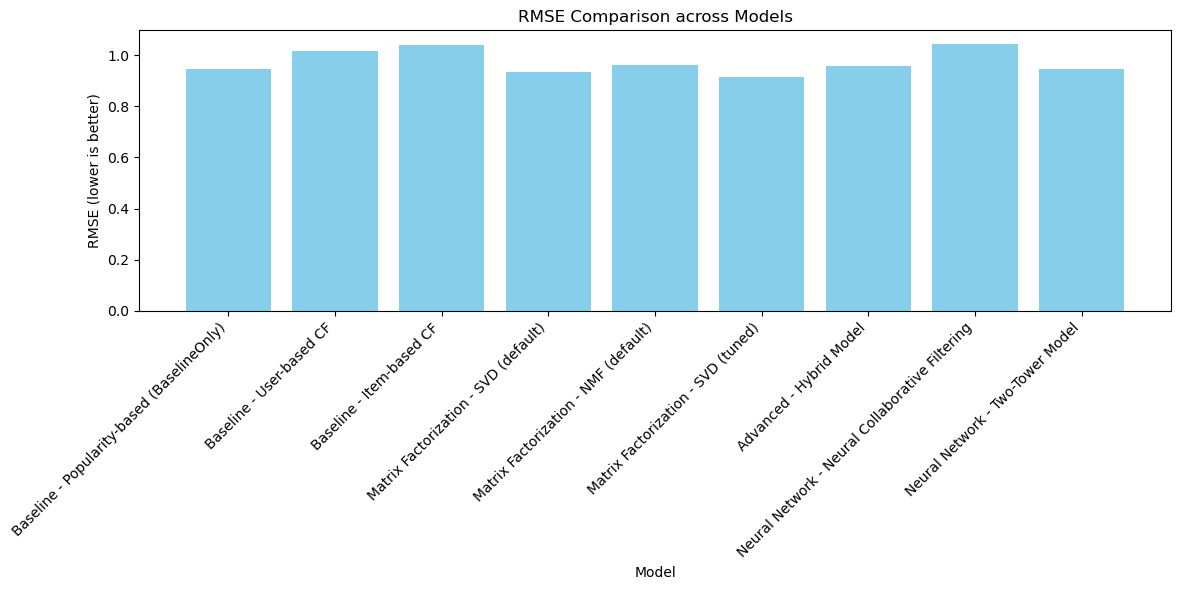

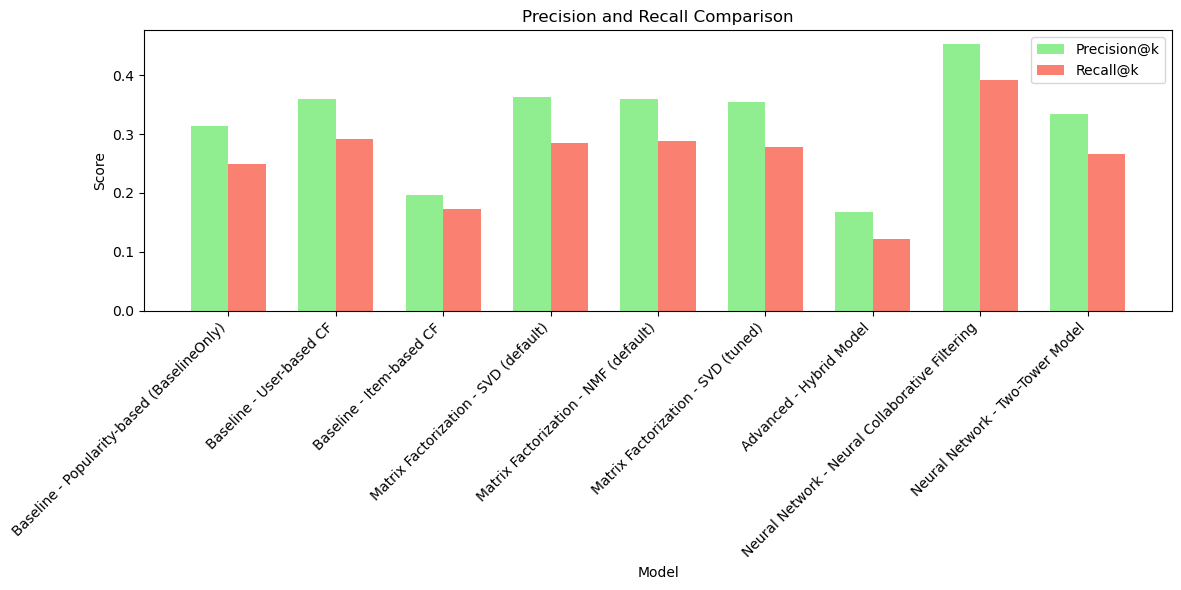

In [4]:
main_with_neural()